In [1]:
import numpy as np
import pickle
import scipy.io as scio
import matplotlib.pyplot as plt
import scipy

In [2]:
##参数设置
c = 3.0e8
k= 2.9982e13  #调频斜率
fs = 1e7 #采样频率
FFTN = 128 #FFT点数
FFTM = 64
FFTQ = 180
rangPoint= 128  #采样点数
Chirp_loops=64
B=1798.92e6 #对应带宽:1798.92 MHz

f0=6e10+B/2
T=0.05/Chirp_loops #脉冲宽度
wavelength=c/f0
d=wavelength/2

In [3]:
TX_numbers=1
RX_numbers=4  #设置发射和接收天线
Num_Channel = TX_numbers*RX_numbers #通道数

In [4]:
mmWave_original_data=scio.loadmat('./mmWave_original_data/test3_Raw_0.mat') #解析从MATLAB中处理后得到的数据

mmwave_rx1=mmWave_original_data['RX1_data'].T
mmwave_rx2=mmWave_original_data['RX2_data'].T
mmwave_rx3=mmWave_original_data['RX3_data'].T
mmwave_rx4=mmWave_original_data['RX4_data'].T

In [5]:
Distance=np.zeros([mmwave_rx1[0:-1:3,:].shape[0],FFTN,RX_numbers],dtype=complex)

Distance[:,:,0] = mmwave_rx1[0:-1:3,:] #T0发R0收
Distance[:,:,1] = mmwave_rx2[0:-1:3,:] #T0发R1收
Distance[:,:,2] = mmwave_rx3[0:-1:3,:] #T0发R2收
Distance[:,:,3] = mmwave_rx4[0:-1:3,:] #T0发R3收

In [6]:
radar_data=np.zeros([FFTN,Distance.shape[0],RX_numbers],dtype=complex)

radar_data[:,:,0]=Distance[:,:,0].T
radar_data[:,:,1]=Distance[:,:,1].T
radar_data[:,:,2]=Distance[:,:,2].T
radar_data[:,:,3]=Distance[:,:,3].T

In [7]:
def hamming(N):
    window = np.array([0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1)) for n in range(N)])
    return window

In [8]:
range_win = hamming(rangPoint)   #加海明窗
doppler_win = hamming(Chirp_loops)
range_profile = np.zeros([FFTN,Chirp_loops,FFTQ],dtype=complex)

In [9]:
mm=np.zeros([rangPoint],dtype=complex)
##消除静态分量(距离仓减慢时间维的均值)
for u in range(Num_Channel):
    for i in range(rangPoint):
        mm[i]=np.mean(radar_data[:,64*(2-1)+i,u])
    for jj in range(int(rangPoint/2)):
        radar_data[jj,Chirp_loops*(2-1)+1:Chirp_loops*(2-1)+Chirp_loops,u]=radar_data[jj,Chirp_loops*(2-1)+i,u]-mm[i]


In [10]:
for u in range(Num_Channel):
    for q in range(int(Chirp_loops-1)):
        radar_data[:,Chirp_loops*(2-1)+q,u]=radar_data[:,Chirp_loops*(2-1)+q+1,u]-radar_data[:,Chirp_loops*(2-1)+q,u]

#距离FFT
for l in range(Num_Channel):
   for m in range(Chirp_loops):
        temp=radar_data[:,Chirp_loops*(2-1)+m,l]*range_win    #加窗函数
        temp_fft=scipy.fft.fft(temp,FFTN)    #对每个chirp做N点FFT
        range_profile[:,m,l]=temp_fft

#多普勒FFT
speed_profile = np.zeros([FFTN,Chirp_loops,Num_Channel],dtype=complex)
for l in range(Num_Channel):
    for n in range(FFTN):
      temp=range_profile[n,:,l]*(doppler_win).T    
      temp_fft=scipy.fft.fftshift(scipy.fft.fft(temp,FFTM))    #对rangeFFT结果进行M点FFT
      speed_profile[n,:,l]=temp_fft  
  
#角度FFT
angle_profile = np.zeros([FFTN,Chirp_loops,FFTQ],dtype=complex)
for n in range(FFTN):   #range
    for m in range(FFTM):   #chirp
      temp=speed_profile[n,m,:]   
      temp_fft=scipy.fft.fftshift(scipy.fft.fft(temp,FFTQ))    #对2D FFT结果进行Q点FFT
      angle_profile[n,m,:]=temp_fft
    


In [11]:
speed_profile_temp = speed_profile[:,:,3].reshape(FFTN,FFTM)


In [12]:
a=np.array(range(0,int(FFTN)))
b=np.array(range(int(-FFTM/2),int(FFTM/2)))

In [13]:
range(int((FFTN-1)*fs*c/FFTN/2/k))

range(0, 49)

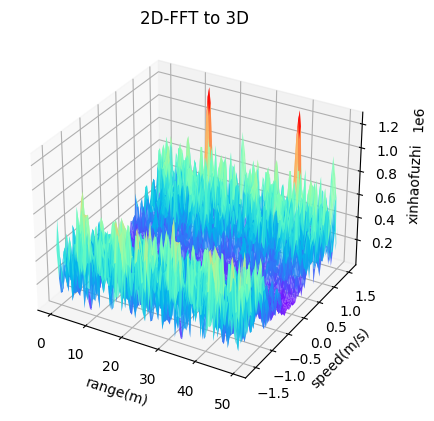

In [16]:
fig = plt.figure()
ax = plt.axes(projection="3d")
speed_profile_temp = speed_profile[:,:,3].reshape(FFTN,FFTM)
speed_profile_Temp = speed_profile_temp.T
X,Y=np.meshgrid(a*fs*c/FFTN/2/k,b*wavelength/T/FFTM/2)

ax.plot_surface(X,Y,np.abs(speed_profile_Temp),alpha=0.9, cstride=1, rstride = 1, cmap='rainbow')

ax.set_xlabel('range(m)')
ax.set_ylabel('speed(m/s)')
ax.set_zlabel('xinhaofuzhi')
ax.set_title('2D-FFT to 3D')
# ax.set_xlim(0,int((FFTN)*fs*c/FFTN/2/k))
# ax.set_ylim(int((-FFTM/2)*wavelength/T/FFTM/2), int((FFTM/2)*wavelength/T/FFTM/2))
plt.ion()  # interactive mode on!!!! 很重要，有了他就不需要plt.show()了


C:\Users\Cola\AppData\Local\Temp\ipykernel_23600\1084908811.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XX, YY, 20*np.log10(np.abs(D)), cmap='jet')


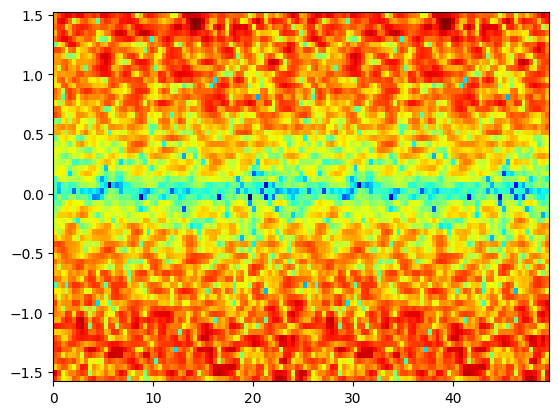

In [34]:
fig = plt.figure()

XX=np.array(range(FFTN))*fs*c/FFTN/2/k
YY=np.array(range(int(-FFTM/2),int(FFTM/2)))*wavelength/T/FFTM/2
D=speed_profile_Temp

for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        if 20*np.log10(np.abs(D[i][j]))<20:
            D[i][j]=0

plt.pcolor(XX, YY, 20*np.log10(np.abs(D)), cmap='jet')

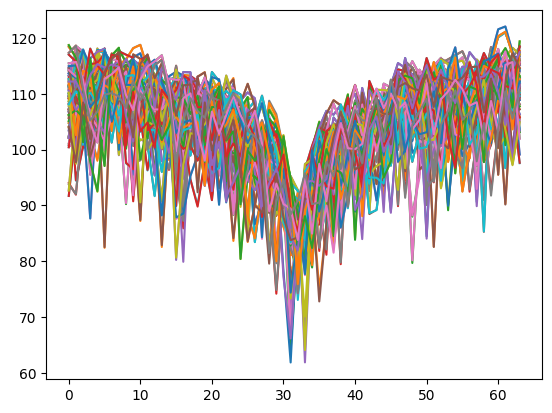

In [35]:
plt.plot(20*np.log10(np.abs(D)))